# Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np 
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from datetime import datetime
import pickle
from sklearn import preprocessing, model_selection
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.notebook import tqdm
import sys
from tabulate import tabulate

# Step 2: Load Data

In [2]:
# Load the ratings.csv file
df = pd.read_csv("ratings.csv")
max = df['userId'].max()
min =df['userId'].min()

# Load the movies.csv file
movies_df = pd.read_csv("movies.csv")

# Step 3: Define Pytorch Dataset

In [3]:
class MovieLensDataset(Dataset):
    def __init__(self, users, movies, ratings):
        self.users = users
        self.movies = movies
        self.ratings = ratings

    def __len__(self):
        return len(self.users)

    def __getitem__(self, item):
        users = self.users[item]
        movies = self.movies[item]
        ratings = self.ratings[item]

        return {
            "users": torch.tensor(users, dtype=torch.long),
            "movies": torch.tensor(movies, dtype=torch.long),
            "ratings": torch.tensor(ratings, dtype=torch.float),
        }

# Step 4: Define Neural Network CF Model

In [4]:
class RecommendationSystemModel(nn.Module):
    def __init__(
        self,
        num_users,
        num_movies,
        embedding_size=256,
        hidden_dim=256,
        dropout_rate=0.2,
    ):
        super(RecommendationSystemModel, self).__init__()
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.hidden_dim = hidden_dim

        # Embedding layers
        self.user_embedding = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.embedding_size
        )
        self.movie_embedding = nn.Embedding(
            num_embeddings=self.num_movies, embedding_dim=self.embedding_size
        )

        # Hidden layers
        self.fc1 = nn.Linear(2 * self.embedding_size, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, 1)

        # Dropout layer
        self.dropout = nn.Dropout(p=dropout_rate)

        # Activation function
        self.relu = nn.ReLU()

    def forward(self, users, movies):
        # Embeddings
        user_embedded = self.user_embedding(users)
        movie_embedded = self.movie_embedding(movies)

        # Concatenate user and movie embeddings
        combined = torch.cat([user_embedded, movie_embedded], dim=1)

        # Pass through hidden layers with ReLU activation and dropout
        x = self.relu(self.fc1(combined))
        x = self.dropout(x)
        output = self.fc2(x)

        return output

# Step 5: Data Preprocessing and Encoding

In [5]:
le_user = preprocessing.LabelEncoder()
le_movie = preprocessing.LabelEncoder()
df.userId = le_user.fit_transform(df.userId.values)
df.movieId = le_movie.fit_transform(df.movieId.values)

# Step 6: Split Dataset

In [6]:
df_train, df_val = model_selection.train_test_split(
    df, test_size=0.1, random_state=3, stratify=df.rating.values
)

# Step 7: Creating Pytorch Dataset

In [7]:
train_dataset = MovieLensDataset(
    users=df_train.userId.values,
    movies=df_train.movieId.values,
    ratings=df_train.rating.values,
)

valid_dataset = MovieLensDataset(
    users=df_val.userId.values,
    movies=df_val.movieId.values,
    ratings=df_val.rating.values,
)


# Step 8: Initializing Data Loaders

In [8]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

# Step 9: Training Loop

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
recommendation_model = RecommendationSystemModel(
    num_users=len(le_user.classes_), 
    num_movies=len(le_movie.classes_),
    embedding_size=128,
    hidden_dim=256,
    dropout_rate=0.1,
).to(device)

optimizer = torch.optim.Adam(recommendation_model.parameters(), lr=1e-3)
loss_func = nn.MSELoss()

EPOCHS = 20

# Function to log progress
def log_progress(epoch, step, total_loss, log_progress_step, data_size, losses):
    avg_loss = total_loss / log_progress_step
    sys.stderr.write(
        f"\r{epoch+1:02d}/{EPOCHS:02d} | Step: {step}/{data_size} | Avg Loss: {avg_loss:<6.9f}"
    )
    sys.stderr.flush()
    losses.append(avg_loss)

total_loss = 0
log_progress_step = 100
losses = []
train_dataset_size = len(train_dataset)
print(f"Training on {train_dataset_size} samples...")

recommendation_model.train()
for e in range(EPOCHS):
    step_count = 0  # Reset step count at the beginning of each epoch
    for i, train_data in enumerate(train_loader):
        output = recommendation_model(
            train_data["users"].to(device), train_data["movies"].to(device)
        )
        # Reshape the model output to match the target's shape
        output = output.squeeze()  # Removes the singleton dimension
        ratings = (
            train_data["ratings"].to(torch.float32).to(device)
        )  # Assuming ratings is already 1D
        loss = loss_func(output, ratings)
        total_loss += loss.sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Increment step count by the actual size of the batch
        step_count += len(train_data["users"])

        # Check if it's time to log progress
        if (
            step_count % log_progress_step == 0 or i == len(train_loader) - 1
        ):  # Log at the end of each epoch
            log_progress(
                e, step_count, total_loss, log_progress_step, train_dataset_size, losses
            )
            total_loss = 0

Training on 90752 samples...


20/20 | Step: 90752/90752 | Avg Loss: 0.031171627

# Step 10: Save the Model for Future Use

In [10]:
torch.save(recommendation_model.state_dict(), "recommendation_model.pt")

# Step 11: Display Average Training Loss

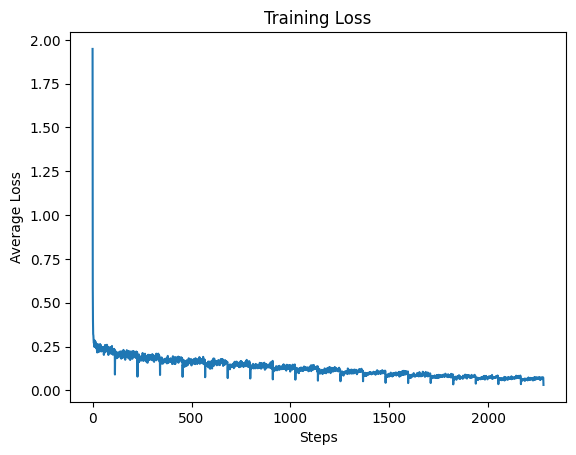

In [11]:
plt.plot(losses)
plt.xlabel("Steps")
plt.ylabel("Average Loss")
plt.title("Training Loss")
plt.show()

# Step 12: Evaluation:

## RMSE (Root Mean Square Error)

In [12]:
y_pred = []
y_true = []

recommendation_model.eval()

with torch.no_grad():
    for i, valid_data in enumerate(val_loader):
        output = recommendation_model(
            valid_data["users"].to(device), valid_data["movies"].to(device)
        )
        y_pred.append(output.sum().item() / len(valid_data["users"]))
        ratings = valid_data["ratings"]
        y_true.append(ratings.sum().item() / len(valid_data["users"]))

rms = root_mean_squared_error(y_true, y_pred)
print(f"rmse: {rms:.4f}")

rmse: 0.1788


## Precision@k and Recall@k

In [13]:
def calculate_precision_recall(user_ratings, k, threshold):
    user_ratings.sort(key=lambda x: x[0], reverse=True)
    n_rel = sum(true_r >= threshold for _, true_r in user_ratings)
    n_rec_k = sum(est >= threshold for est, _ in user_ratings[:k])
    n_rel_and_rec_k = sum((true_r >= threshold) and (est >= threshold) for est, true_r in user_ratings[:k])

    precision = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
    recall = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
    return precision, recall

user_ratings_comparison = defaultdict(list)

with torch.no_grad():
    for valid_data in val_loader:
        users = valid_data["users"].to(device)
        movies = valid_data["movies"].to(device)
        ratings = valid_data["ratings"].to(device)
        output = recommendation_model(users, movies)

        for user, pred, true in zip(users, output, ratings):
            user_ratings_comparison[user.item()].append((pred[0].item(), true.item()))

user_precisions = dict()
user_based_recalls = dict()

k = 50
threshold = 3

for user_id, user_ratings in user_ratings_comparison.items():
    precision, recall = calculate_precision_recall(user_ratings, k, threshold)
    user_precisions[user_id] = precision
    user_based_recalls[user_id] = recall


average_precision = sum(prec for prec in user_precisions.values()) / len(user_precisions)
average_recall = sum(rec for rec in user_based_recalls.values()) / len(user_based_recalls)

print(f"precision @ {k}: {average_precision:.4f}")
print(f"recall @ {k}: {average_recall:.4f}")

precision @ 50: 0.8989
recall @ 50: 0.8237


# Step 13: Recommend Top 5 Movies

In [14]:
def recommend_top_n_movies(n):
    while True:
        original_user_id = int(input("Enter a user ID: "))
        if original_user_id <= max and original_user_id >= min:
            break
        else:
            print("Invalid user ID. Please try again.")
        
    user_id = le_user.transform([original_user_id])[0]
    
    all_movie_ids = set(df.movieId.unique())
    
    seen_movie_ids = set(df[df.userId == user_id].movieId.unique())
    
    original_seen_movie_ids = le_movie.inverse_transform(list(seen_movie_ids))
    
    seen_movies = movies_df[movies_df['movieId'].isin(original_seen_movie_ids)]
    
    # Print the seen movies
    print("Movies you've seen:")
    print(tabulate(seen_movies[['movieId', 'title']], headers='keys', tablefmt='psql', showindex=False))
    
    unseen_movie_ids = all_movie_ids - seen_movie_ids
    unseen_movie_ids = list(unseen_movie_ids)
    
    users = [user_id] * len(unseen_movie_ids)
    movies = unseen_movie_ids
    ratings = [0] * len(unseen_movie_ids)  # dummy ratings
    
    dataset = MovieLensDataset(users, movies, ratings)
    data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
    
    recommendation_model.eval()
    predicted_ratings = []
    with torch.no_grad():
        for data in data_loader:
            output = recommendation_model(data["users"].to(device), data["movies"].to(device))
            predicted_ratings.extend(output.squeeze().tolist())
    
    movie_ratings = list(zip(unseen_movie_ids, predicted_ratings))
    
    movie_ratings.sort(key=lambda x: x[1], reverse=True)
    
    top_n_movie_ids = []
    top_n_movie_names = []
    for movie_id, _ in movie_ratings:
        if movie_id in movies_df.movieId.values:
            top_n_movie_ids.append(movie_id)
            movie_index = movies_df[movies_df.movieId == movie_id].index[0]
            top_n_movie_names.append(movies_df.title.values[movie_index])
            if len(top_n_movie_ids) == n:
                break

    return top_n_movie_ids,top_n_movie_names


n = 5  
top_n_ids ,top_n_movies = recommend_top_n_movies(n)

Enter a user ID:  1


Movies you've seen:
+-----------+--------------------------------------------------------------------------------+
|   movieId | title                                                                          |
|-----------+--------------------------------------------------------------------------------|
|         1 | Toy Story (1995)                                                               |
|         3 | Grumpier Old Men (1995)                                                        |
|         6 | Heat (1995)                                                                    |
|        47 | Seven (a.k.a. Se7en) (1995)                                                    |
|        50 | Usual Suspects, The (1995)                                                     |
|        70 | From Dusk Till Dawn (1996)                                                     |
|       101 | Bottle Rocket (1996)                                                           |
|       110 | Braveheart (1995

In [15]:
print(f"\nBased on your user preference above, we recommend the following top {n} movies for you:")
for i in range(n):
    print(f"{i+1}. {top_n_movies[i]} (ID: {top_n_ids[i]})")


Based on your user preference above, we recommend the following top 5 movies for you:
1. Elling (2001) (ID: 5890)
2. Modern Problems (1981) (ID: 5768)
3. It Came from Outer Space (1953) (ID: 2661)
4. Moby Dick (1956) (ID: 4429)
5. Happy Go Lovely (1951) (ID: 3315)
